In [1]:
%matplotlib inline


In [2]:
%%html
<style>
div.input {
    display:none;
}
</style>


## Project 5 Writeup: Advanced Lane Finding


**by Patrick Poon**

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

## Rubric Points
### Here I will consider the [rubric points](https://review.udacity.com/#!/rubrics/571/view) individually and describe how I addressed each point in my implementation.  

---
### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  


The write-up and README file were created with the Jupyter Notebook input cells folded.  To see the code used to generate the images, please refer to the **`writeup_worksheet.ipyb`** file in which the input cells are expanded.

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is in the **`get_calibration_pts`** function in lines 17-47 in the file, **`calibrate_camera.py`**.

I start by preparing "object points", which represent the (x, y, z) coordinates of chessboard corners in virtual space. I assume the chessboard is fixed on the (x, y) plane at z=0, so that the object points are equivalent for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and every time I successfully detect all chessboard corners in a test image, `objpoints` will be appended with a copy of it.  With each successful chessboard detection, `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane.  

At this point, I used the resulting `objpoints` and `imgpoints` arrays to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I then applied this distortion correction to a test image using the `cv2.undistort()` function and obtained the following result: 


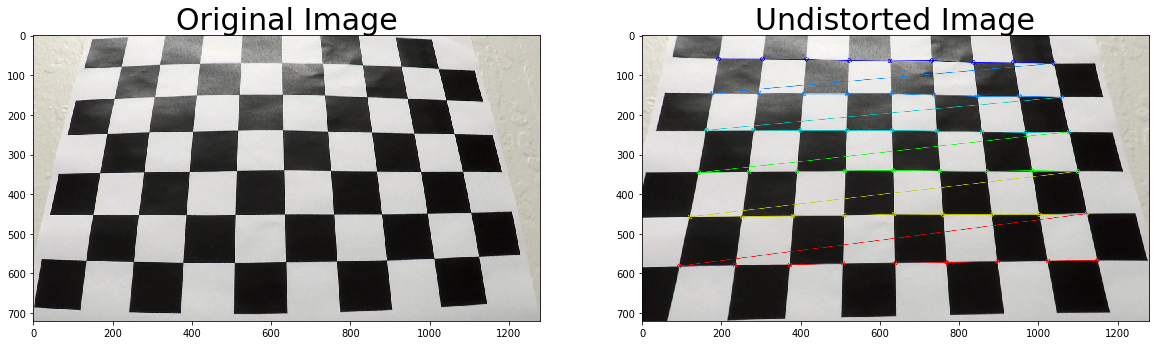

In [3]:
# %load calibrate_camera.py
import cv2
from glob import iglob
import matplotlib.pyplot as plt
import numpy as np
import pickle


def get_corners(gray_image, pts_per_row, pts_per_column, flags=None):
    return cv2.findChessboardCorners(gray_image, (pts_per_row, pts_per_column), flags)


def draw_image_corners(image, pts_per_row, pts_per_column, corners, ret):
    cornered = cv2.drawChessboardCorners(image, (pts_per_row, pts_per_column), corners, ret)
    return cornered


def get_calibration_pts(img_files_regex, pts_per_row, pts_per_column, num_channels):
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((pts_per_column * pts_per_row, 3), np.float32)
    objp[:,:2] = np.mgrid[0:pts_per_row, 0:pts_per_column].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = iglob(img_files_regex)

    # Step through the list and search for chessboard corners
    for idx, filename in enumerate(images, start=1):
        img = cv2.imread(filename)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = get_corners(gray, pts_per_row, pts_per_column)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = draw_image_corners(img, pts_per_row, pts_per_column, corners, ret)
            write_name = './test_out/corners_found'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)

    return objpoints, imgpoints


def undistort_image(image, matrix, distortion_coefficients):
    return cv2.undistort(image, matrix, distortion_coefficients, None, matrix)


def get_calibration_data():
    # Read in the saved camera matrix and distortion coefficients
    # These are the arrays you calculated using cv2.calibrateCamera()
    return pickle.load( open( "./output_images/calibration.p", "rb" ) )


if __name__ == '__main__':
    img_files_regex = './camera_cal/calibration*.jpg'
    pts_per_row = 9
    pts_per_column = 6
    num_channels = 3

    objpoints, imgpoints = get_calibration_pts(img_files_regex, pts_per_row, pts_per_column, num_channels)

    # Test undistortion on an image
    img = cv2.imread('./camera_cal/calibration3.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, matrix, distortion_coefficients, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # Save the camera calibration results
    dist_pickle = {}
    dist_pickle["mtx"] = matrix
    dist_pickle["dist"] = distortion_coefficients
    pickle.dump( dist_pickle, open( "./output_images/calibration.p", "wb" ) )

    # Undistort image and save results to file
    undistorted = undistort_image(img, matrix, distortion_coefficients)
    undistorted_gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)
    ret, corners = get_corners(undistorted_gray, pts_per_row, pts_per_column)
    undistorted = draw_image_corners(undistorted, pts_per_row, pts_per_column, corners, ret)
    cv2.imwrite('test_out/test_undist.jpg', undistorted)

    # Visualize distortion correction
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=30)


### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

To ensure that my calibration results would work on the driving images, I tested the results against the `signs_vehicles_xygrad.png` image from the "Combining Thresholds" lesson in the "Advanced Lane Finding" module of the Udacity curriculum.  The file can be found in the `./test_images/` directory.

The image is quite distorted.  I loaded the calibration matrix and distortion coefficients, and fed them in the `cv2.undistort()` function along with the image in line 51 of the `calibrate_camera.py` file.  Here are the results:


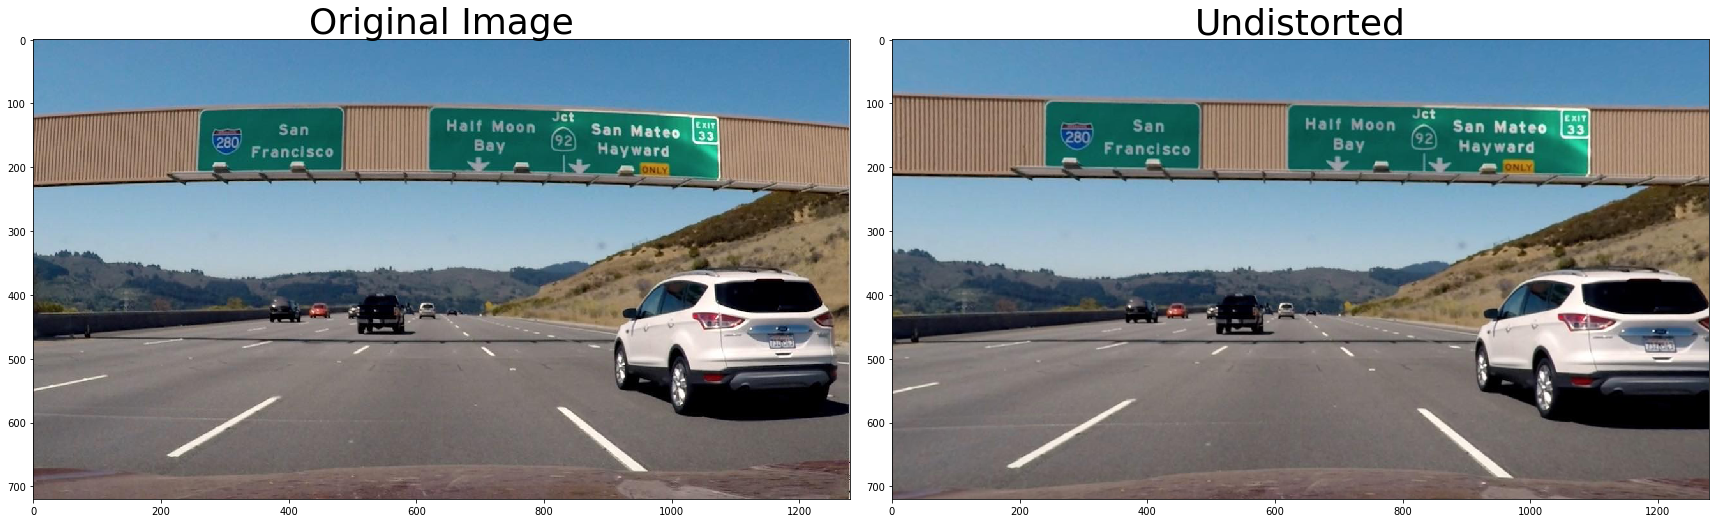

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from calibrate_camera import get_calibration_data, undistort_image

calibration = get_calibration_data()
matrix = calibration['mtx']
distortion_coefficients = calibration['dist']
orig_img = cv2.cvtColor(cv2.imread('./test_images/signs_vehicles_xygrad.png'), cv2.COLOR_BGR2RGB)
img = undistort_image(orig_img, matrix, distortion_coefficients)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(orig_img)
ax1.set_title('Original Image', fontsize=36)
ax2.imshow(img)
ax2.set_title('Undistorted', fontsize=36);


The calibration results appear to be working effectively.

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I wrote functions to generate a variety of threshold binaries, namely absolute Sobel, directional, magnitude, and color, in lines 9 to 107 in **`thresholds.py`**.  Images of each threshold binary is shown below.  I found the combined color threshold to be the most effective in detecting the lane lines, even with a shadow obscuring a part of the lane.

Using `cv2.cvtColor` function to obtain the HLS (Hue, Lightness, and Saturation) values for the image, I was able to extract the Lightness and Saturation channels and use them with the `cv2.Sobel` operator to calculate a binary that effectively detects the lanes in lines 79-107 in `thresholds.py`.  Please see the **Thresholded Gradient [Combined]** image below for the result:


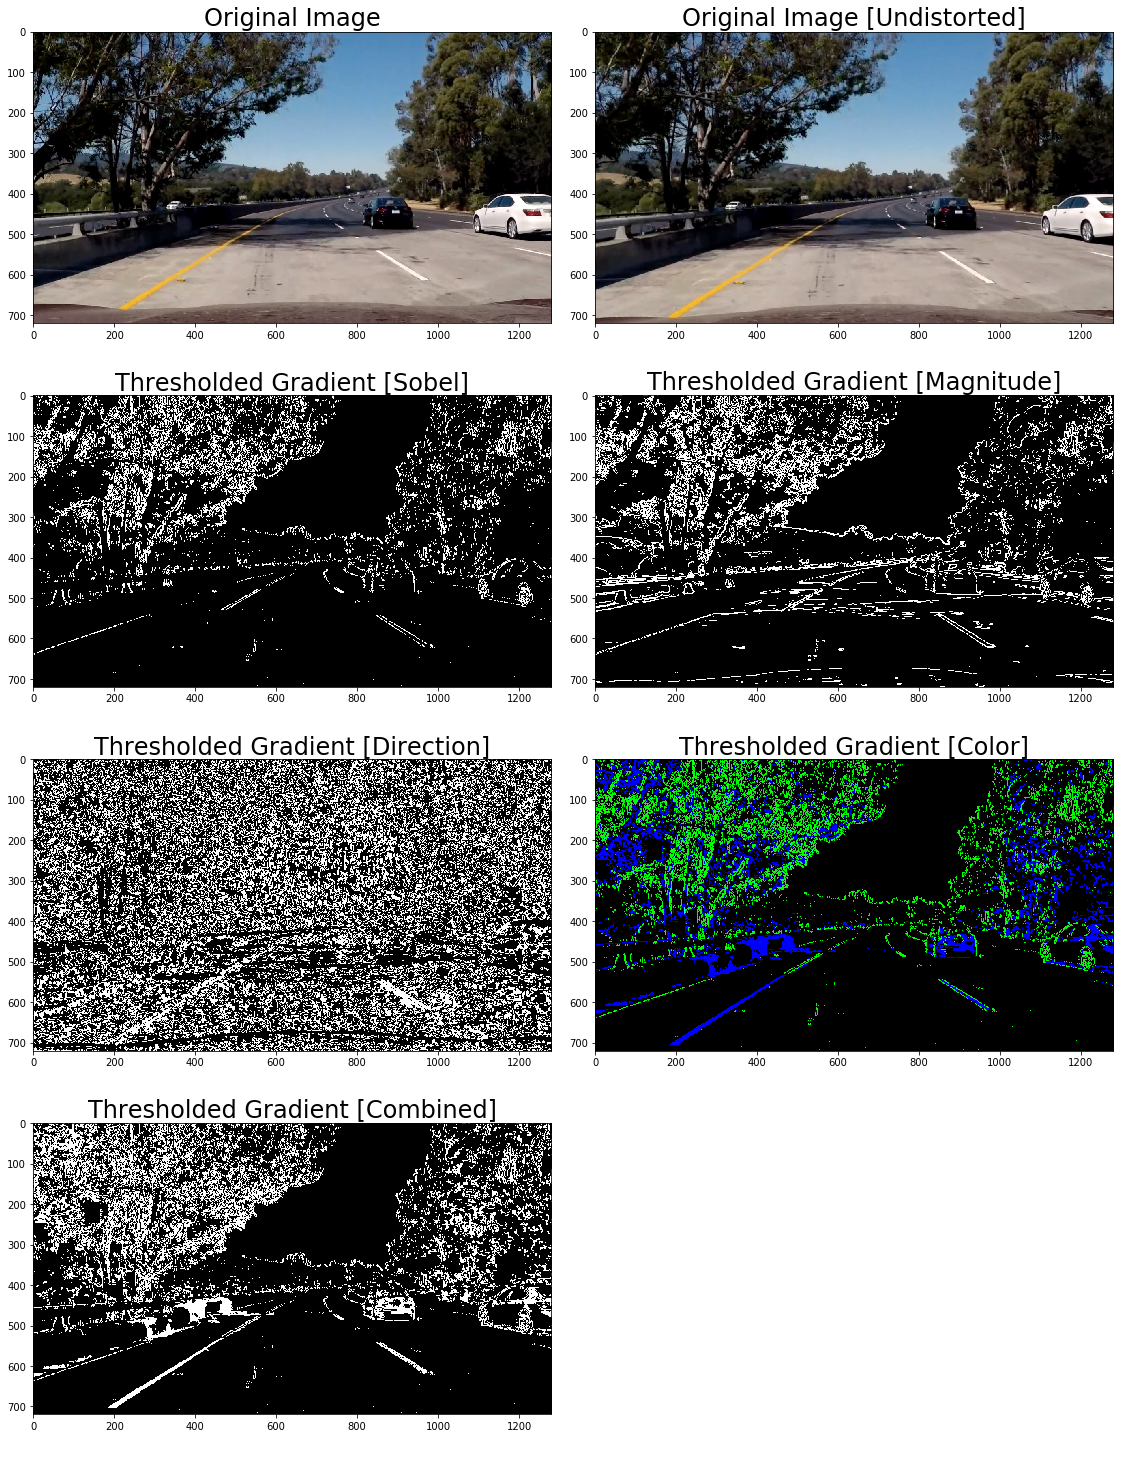

In [5]:
import cv2
import matplotlib.pyplot as plt
from calibrate_camera import get_calibration_data, undistort_image
from thresholds import get_abs_sobel_thresh, get_magnitude_threshold, get_direction_threshold, get_color_threshold


calibration = get_calibration_data()
matrix = calibration['mtx']
distortion_coefficients = calibration['dist']
image_file = './test_images/test5.jpg'
orig_img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
img = undistort_image(orig_img, matrix, distortion_coefficients)

# Binaries
orient = 'x'
min = 20
max = 100
threshed = get_abs_sobel_thresh(img, orient, min, max)
mag_binary = get_magnitude_threshold(img, sobel_kernel=3, mag_thresh=(30, 100))
dir_binary = get_direction_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
color_binary, combined_binary = get_color_threshold(img)

# Plot the result
f, ax = plt.subplots(4, 2, figsize=(15, 22))
f.tight_layout()
ax[0, 0].imshow(orig_img)
ax[0, 0].set_title('Original Image', fontsize=24)
ax[0, 1].imshow(img)
ax[0, 1].set_title('Original Image [Undistorted]', fontsize=24)
ax[1, 0].imshow(threshed, cmap='gray')
ax[1, 0].set_title('Thresholded Gradient [Sobel]', fontsize=24)
ax[1, 1].imshow(mag_binary, cmap='gray')
ax[1, 1].set_title('Thresholded Gradient [Magnitude]', fontsize=24)
ax[2, 0].imshow(dir_binary, cmap='gray')
ax[2, 0].set_title('Thresholded Gradient [Direction]', fontsize=24)
ax[2, 1].imshow(color_binary)
ax[2, 1].set_title('Thresholded Gradient [Color]', fontsize=24)
ax[3, 0].imshow(combined_binary, cmap='gray')
ax[3, 0].set_title('Thresholded Gradient [Combined]', fontsize=24)
ax[3, 1].axis('off')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

To perform a perspective transform on the road images, I used a function called `warper()`, which appears in lines 4 through 8 in the `warper.py` file (./warper.py).  The `warper()` function accepts an image (`image`), as well as source (`src`) and destination (`dst`) points as inputs.

I used the `./test_images/straight_lines1.jpg` as my source file.  With the GIMP image manipulation application, I determined the specific region of interest I would warp to detect the lanes.  I calibrated the points by warping the image and adjusting until the lines were vertically straight.  Here are the final source and destination points I chose:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 592, 450      | 250, 0        | 
| 686, 450      | 1030, 0       |
| 1120, 720     | 1030, 720     |
| 180, 720      | 250, 720      |


To confirm that my perspective transform succeeded, I printed the original image, undistorted it, drew lines between the region of interest `src` points, and finally warped the image to provide a "bird's eye" view, using the `dst` points:


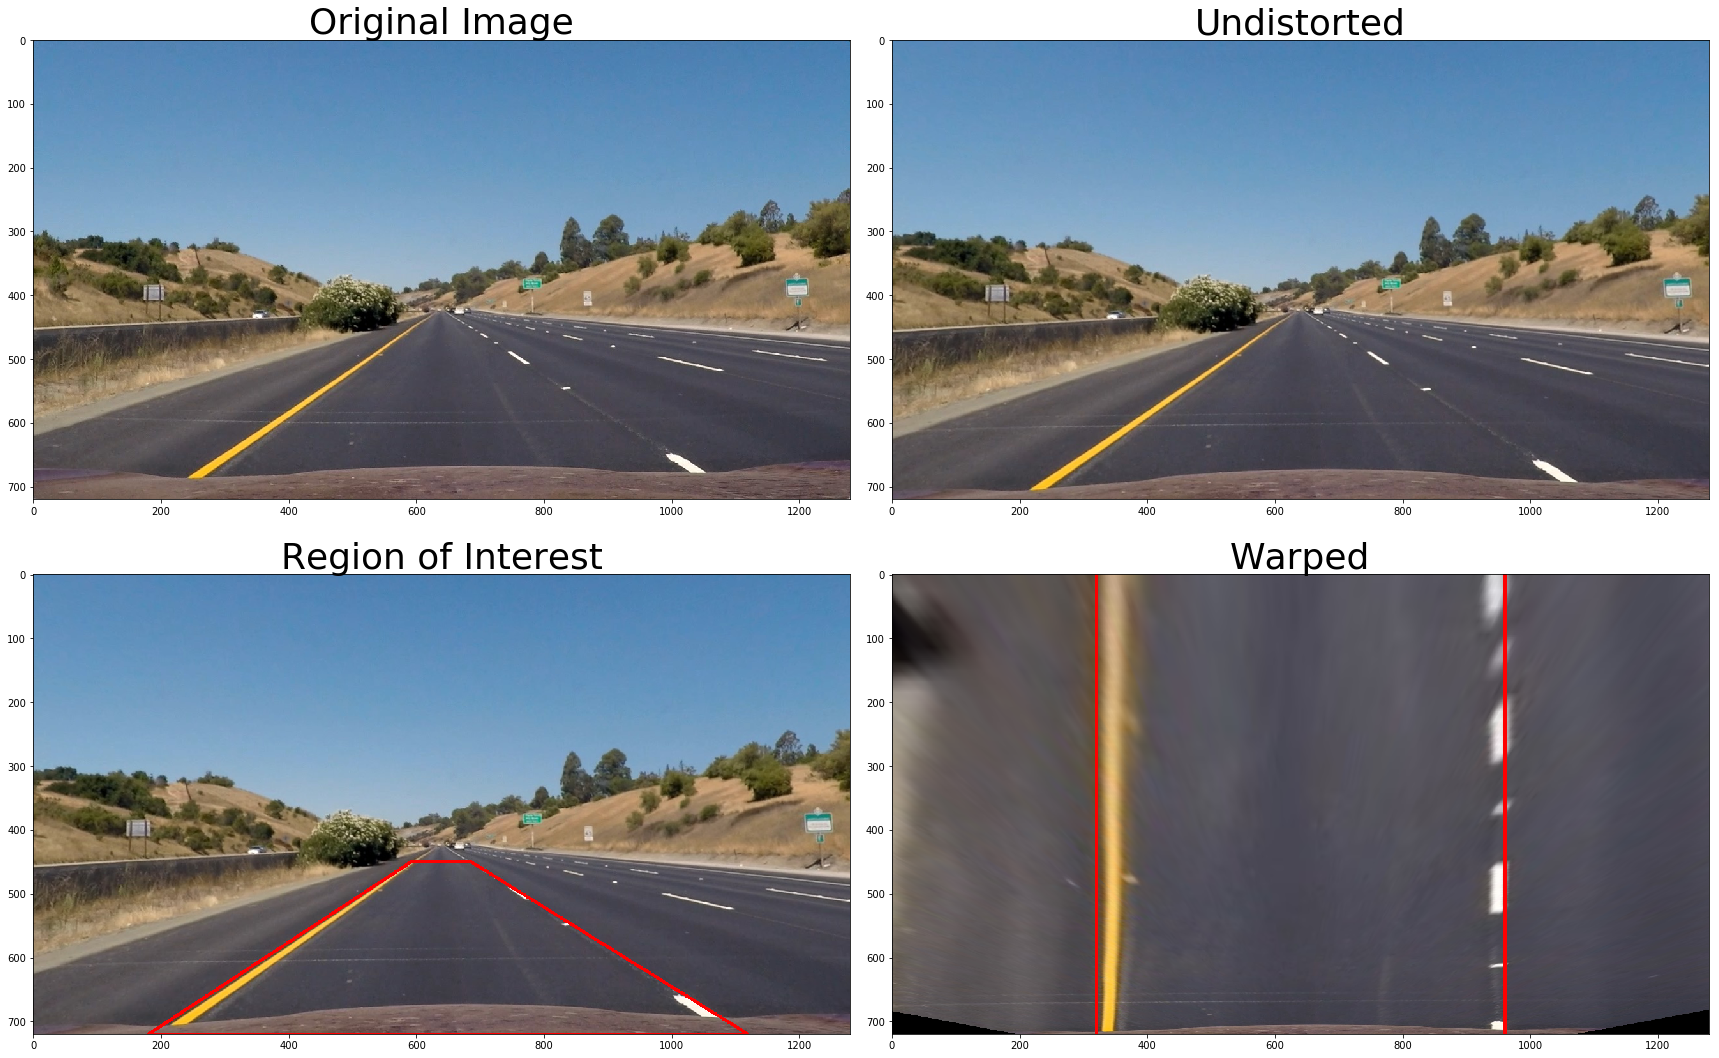

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from calibrate_camera import get_calibration_data, undistort_image
from warper import get_dst_pts, get_src_pts, warper


LINE_THICKNESS = 4
LINE_COLOR = [255, 0, 0]
TOP = 450
BOTTOM = 720

# Image warping source and destination points
left_top = (592, TOP)
left_bottom = (180, BOTTOM)
right_top = (686, TOP)
right_bottom = (1120, BOTTOM)

src = np.float32([
    [left_top[0], left_top[1]],
    [right_top[0], right_top[1]],
    [right_bottom[0], right_bottom[1]],
    [left_bottom[0], left_bottom[1]]
])

dst_left = 320
dst_right = 960
dst = np.float32([
    [dst_left, 0],
    [dst_right, 0],
    [dst_right, 720],
    [dst_left, 720]
])

# Get camera calibration data
calibration = get_calibration_data()
calibration_matrix = calibration['mtx']
distortion_coefficients = calibration['dist']

# Undistort image
orig_img = cv2.cvtColor(cv2.imread('./test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)
img = undistort_image(orig_img, calibration_matrix, distortion_coefficients)
img_size = (img.shape[1], img.shape[0])

# Draw region of interest trapezoid
img_copy = np.copy(img)
cv2.line(img_copy, left_bottom, left_top, LINE_COLOR, LINE_THICKNESS)
cv2.line(img_copy, right_bottom, right_top, LINE_COLOR, LINE_THICKNESS)
cv2.line(img_copy, left_top, right_top, LINE_COLOR, LINE_THICKNESS)
cv2.line(img_copy, left_bottom, right_bottom, LINE_COLOR, LINE_THICKNESS)

# Warp image and draw red guides
warped = warper(img, src, dst)
warped_lines = np.copy(warped)
cv2.line(warped_lines, (dst_left, 0), (dst_left, 720), LINE_COLOR, LINE_THICKNESS)
cv2.line(warped_lines, (dst_right, 0), (dst_right, 720), LINE_COLOR, LINE_THICKNESS)

f, ax = plt.subplots(2, 2, figsize=(24, 15))
f.tight_layout()
ax[0, 0].set_title('Original Image', fontsize=36)
ax[0, 0].imshow(orig_img)
ax[0, 1].set_title('Undistorted', fontsize=36)
ax[0, 1].imshow(img)
ax[1, 0].set_title('Region of Interest', fontsize=36)
ax[1, 0].imshow(img_copy)
ax[1, 1].set_title('Warped', fontsize=36)
ax[1, 1].imshow(warped_lines);


#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Applying the warper() function to the `./test_images/test5.jpg` image, I get the warped image below.  I created a histogram of the bottom half of the image to determine a base point to start detecting lanes.  

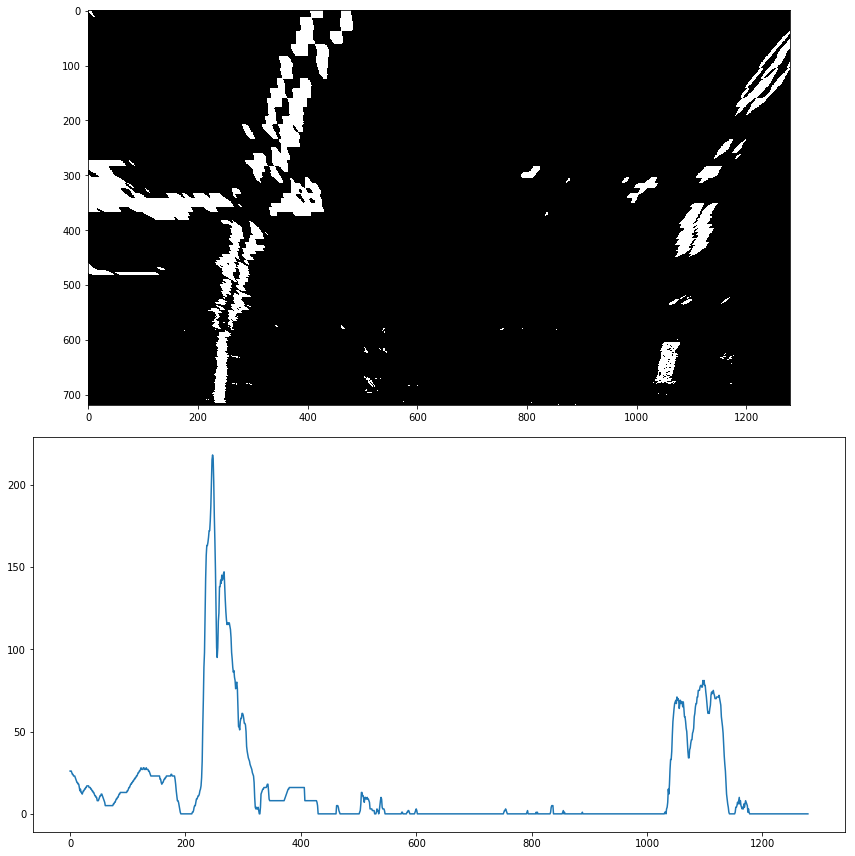

In [7]:
import cv2
import matplotlib.pyplot as plt
from calibrate_camera import get_calibration_data, undistort_image
from thresholds import get_color_threshold
from warper import get_dst_pts, get_src_pts, warper


calibration = get_calibration_data()
matrix = calibration['mtx']
distortion_coefficients = calibration['dist']

image_file = './test_images/test5.jpg'
orig_img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
img = undistort_image(orig_img, matrix, distortion_coefficients)
_, combined_binary = get_color_threshold(img)

combined_binary_img_size = (combined_binary.shape[1], combined_binary.shape[0])
src = get_src_pts()
dst = get_dst_pts()
binary_warped = warper(combined_binary, src, dst)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
f.tight_layout()
ax1.imshow(binary_warped, cmap='gray');
ax2.plot(histogram);


I used NumPy's `argmax()` function to determine the peak points for the left and right halves of the image (please see lines 115-121 in `generate_video.py`).  I then slice the peak point region into nine windows in which I extract line pixel positions for each lane with the purpose of fitting a second order polynomial to each lane marker (lines 149-193 in `generate_video.py`).  The polynomials are fitted using NumPy's `polyfit()` function in lines 192-193.  Here is the result:

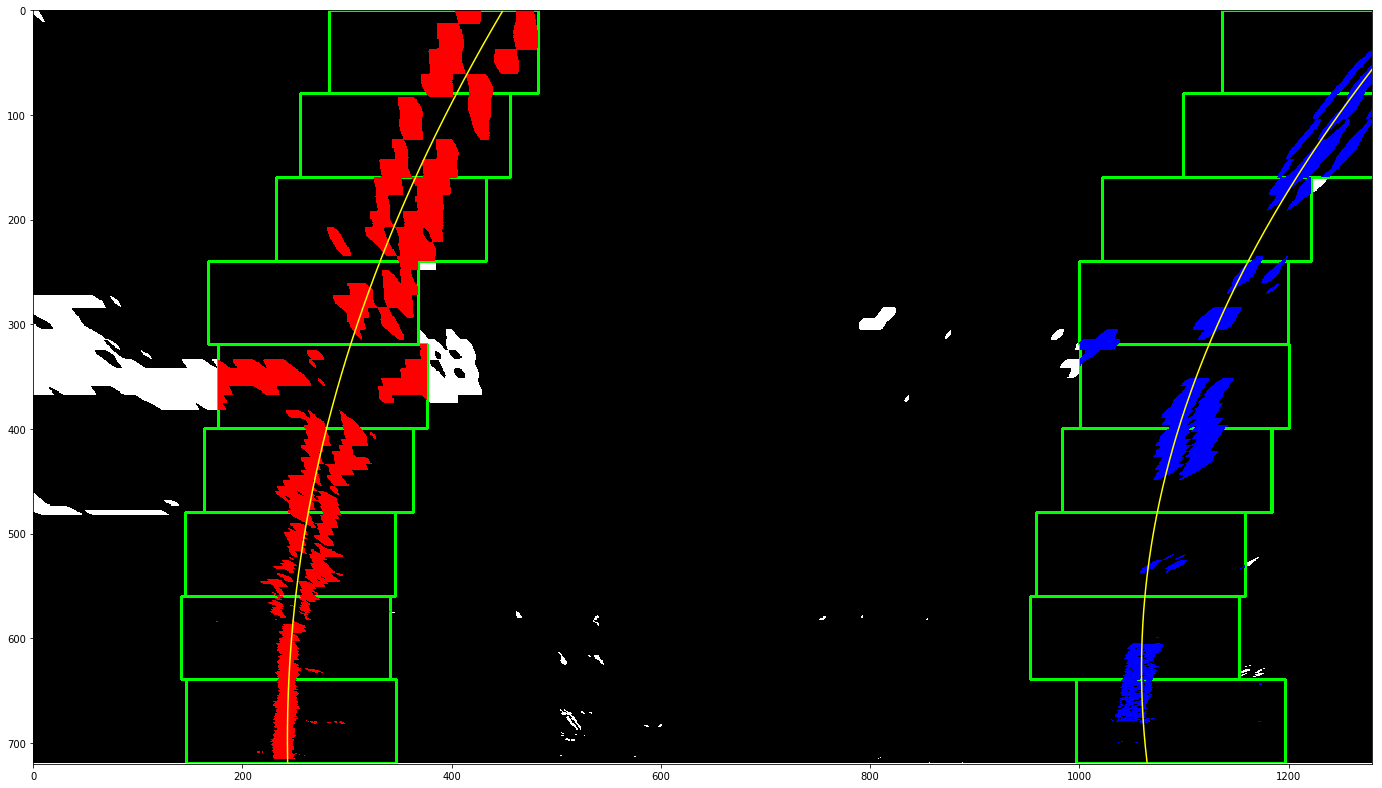

In [8]:
import cv2
import matplotlib.pyplot as plt
from calibrate_camera import get_calibration_data, undistort_image
from thresholds import get_color_threshold
from warper import get_dst_pts, get_src_pts, warper


calibration = get_calibration_data()
matrix = calibration['mtx']
distortion_coefficients = calibration['dist']

image_file = './test_images/test5.jpg'
orig_img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
img = undistort_image(orig_img, matrix, distortion_coefficients)
_, combined_binary = get_color_threshold(img)

combined_binary_img_size = (combined_binary.shape[1], combined_binary.shape[0])
src = get_src_pts()
dst = get_dst_pts()
binary_warped = warper(combined_binary, src, dst)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9

# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - ((window + 1) * window_height)
    win_y_high = binary_warped.shape[0] - (window * window_height)
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
    cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2) 

    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & 
                      (nonzeroy < win_y_high) & 
                      (nonzerox >= win_xleft_low) & 
                      (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & 
                       (nonzeroy < win_y_high) & 
                       (nonzerox >= win_xright_low) & 
                       (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(figsize=(24,24))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0);

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

With the polynomials calculated in the last step, I use them with the following conversion factors to calculate the radius of the left and right lane markers:
```
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
```
These calculations are done in lines 196-197 in `generate_video.py` for the left and right lane markers.  I then average them in line 211 to calculate an overall curvature radius in meters.  Calculation of the distance from the center is performed in lines 214-215, where I take the average point between the left and right base points and subtract the center of the image where the camera is situated.  The resulting value is converted to meters using the `xm_per_pix` conversion factor above.

In [9]:
# Plot the data
# mark_size = 3
# plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
# plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
# plt.xlim(0, 1280)
# plt.ylim(0, 720)
# plt.plot(left_fitx, ploty, color='green', linewidth=3)
# plt.plot(right_fitx, ploty, color='green', linewidth=3)
# plt.gca().invert_yaxis() # to visualize as we do the images

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
# print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Now our radius of curvature is in meters
# print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

Using the second order polynomials above, I painted the region between the lanes onto a warped blank image.  This image is then warped back to the original image space using the inverse perspective matrix (`Minv`).  Finally, I annotate the image with the lane curvature radius and distance from center.  Please refer to lines 199-235 in `generate_video.py` for code details.  Here is the result:

---

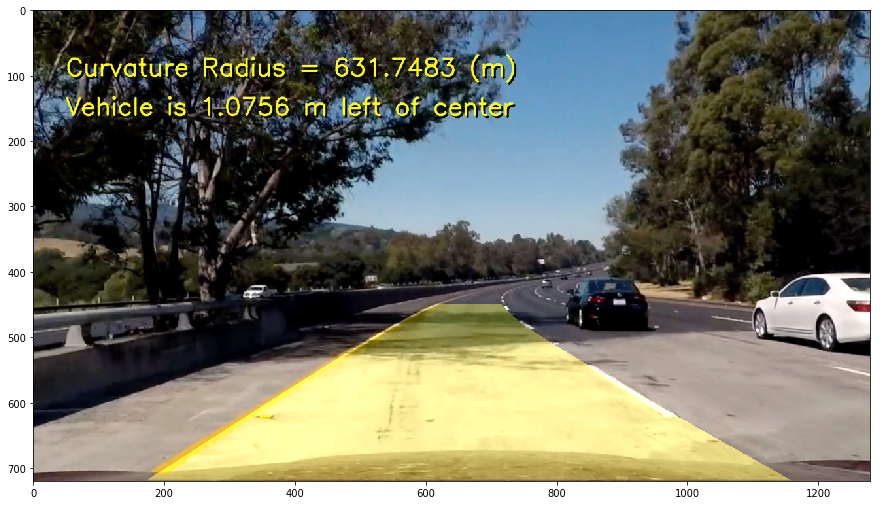

In [10]:
import cv2
import matplotlib.image as mpimg
import matplotlib.patheffects as path_effects
import numpy as np
from calibrate_camera import get_calibration_data, undistort_image
from thresholds import get_color_threshold
from warper import get_dst_pts, get_src_pts, warper
from warper import warper


calibration = get_calibration_data()
matrix = calibration['mtx']
distortion_coefficients = calibration['dist']

image = mpimg.imread('./test_images/test5.jpg')
undistorted = undistort_image(image, matrix, distortion_coefficients)
_, combined_binary = get_color_threshold(undistorted)

src = get_src_pts()
dst = get_dst_pts()
binary_warped = warper(combined_binary, src, dst)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9

# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - ((window + 1) * window_height)
    win_y_high = binary_warped.shape[0] - (window * window_height)
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) &
                      (nonzeroy < win_y_high) &
                      (nonzerox >= win_xleft_low) &
                      (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) &
                       (nonzeroy < win_y_high) &
                       (nonzerox >= win_xright_low) &
                       (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds]
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
# Example values: 1926.74 1908.48

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (255, 255, 0))

# Drop shadow
avg_curve_radius = np.mean([left_curverad + right_curverad])
text_curve_radius = 'Curvature Radius = {:.4f} (m)'.format(avg_curve_radius)

lane_center = (leftx_current + rightx_current) / 2
lane_off_center = (lane_center - (image.shape[1] / 2)) * xm_per_pix
text_center_off = 'Vehicle is {:.4f} m {} of center'.format(abs(lane_off_center), 'left' if lane_off_center > 0 else 'right')

# Drop shadow
font = cv2.FONT_HERSHEY_SIMPLEX
fontscale = 1.25
thickness = 2
cv2.putText(
    undistorted,
    text_curve_radius,
    (53, 103),
    font,
    fontscale,
    (0, 0, 0),
    thickness,
    cv2.LINE_AA
)
cv2.putText(
    undistorted,
    text_curve_radius,
    (50, 100),
    font,
    fontscale,
    (255, 255, 0),
    thickness,
    cv2.LINE_AA
)

# Primary color
cv2.putText(
    undistorted,
    text_center_off,
    (53, 163),
    font,
    fontscale,
    (0, 0, 0),
    thickness,
    cv2.LINE_AA
)
cv2.putText(
    undistorted,
    text_center_off,
    (50, 160),
    font,
    fontscale,
    (255, 255, 0),
    thickness,
    cv2.LINE_AA
)

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = warper(color_warp, dst, src)

# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
fig = plt.figure(figsize=(15, 9))
plt.imshow(result);


In [11]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from calibrate_camera import get_calibration_data, undistort_image
from IPython.display import HTML
from moviepy.editor import VideoFileClip
from thresholds import get_color_threshold
from warper import get_dst_pts, get_src_pts, warper

calibration = get_calibration_data()
matrix = calibration['mtx']
distortion_coefficients = calibration['dist']


def pipeline(image):
    orig_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = undistort_image(orig_img, matrix, distortion_coefficients)
    _, combined_binary = get_color_threshold(img)

    combined_binary_img_size = (combined_binary.shape[1], combined_binary.shape[0])
    src = get_src_pts()
    dst = get_dst_pts()
    binary_warped = warper(combined_binary, src, dst)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print('midpoint = {}'.format(midpoint))
    print('leftx_base = {}  rightx_base = {}'.format(leftx_base, rightx_base))

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - ((window + 1) * window_height)
        win_y_high = binary_warped.shape[0] - (window * window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & 
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & 
                           (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) & 
                           (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(img, np.int_([pts]), (255, 255, 0))

    # Drop shadow
    cv2.putText(
        img,
        'Curvature Radius = 651 (m)',
        (53, 103),
        0,
        2,
        (0, 0, 0),
        5,
        cv2.LINE_AA
    )
    cv2.putText(
        img,
        'Curvature Radius = 651 (m)',
        (50, 100),
        0,
        2,
        (255, 255, 0),
        5,
        cv2.LINE_AA
    )

    # Primary color
    cv2.putText(
        img,
        'Vehicle is {}m {} of center'.format(0.5, 'left'),
        (53, 163),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (0, 0, 0),
        5,
        cv2.LINE_AA
    )
    cv2.putText(
        img,
        'Vehicle is {}m {} of center'.format(0.5, 'left'),
        (50, 160),
        cv2.FONT_HERSHEY_SIMPLEX,
        2,
        (255, 255, 0),
        5,
        cv2.LINE_AA
    )

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warper(color_warp, dst, src)

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
#     fig = plt.figure(figsize=(15, 9))
#     plt.imshow(result);
    return result


In [12]:
# video_output = 'yellow_brick_road.mp4'
# clip1 = VideoFileClip("project_video.mp4")
# yellow_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
# %time yellow_clip.write_videofile(video_output, audio=False)

In [13]:
# HTML("""
# <video width="960" height="540" controls>
#   <source src="{0}">
# </video>
# """.format('https://youtu.be/W0xzcFRIw2g'))

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](https://youtu.be/W0xzcFRIw2g).  A copy of the movie file can be found at `./yellow_brick_road.mp4`.

---

In [14]:
HTML('<iframe width="978" height="550" src="https://www.youtube.com/embed/W0xzcFRIw2g" frameborder="0" allowfullscreen></iframe>')


### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

The main problem I encountered is when the road goes from dark to light asphalt.  My pipeline had difficulty detecting the lane due to low contrast between the lane markers and the road.  

My pipeline will likely fail in regions where there is low contrast between the lane markers and the road.  I could potentially make my pipeline more robust by testing a mix of threshold binaries that would perform better in detecting lanes in low contrast conditions.